## Single Object Detection using Pytorch on Pascal VOC 2007 dataset
### Understanding the Pascal VOC
Pacal VOC can be download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). The orginal annotations were in XML. The json annotations can be downloaded from [here](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip)

In [24]:
import os
from pathlib import Path
import json
import random
import math
import numpy as np
import pandas as pd
import collections

from matplotlib import pyplot as plt
from matplotlib import patches, patheffects
import cv2

from fastai.conv_learner import resnet34, ConvLearner, accuracy, OptimScheduler,predict_batch
from fastai.dataset import optim, ImageClassifierData
from fastai.transforms import *

import torch

from fastai.dataset import open_image

%matplotlib  inline
%reload_ext autoreload
%autoreload 2

torch.cuda.set_device(0)

In [2]:
#set paths to the pascal json files
homedir = os.path.expanduser('~')
pascal_home = Path(os.path.join(homedir,'data/pascal_voc'))
pascal_jhome = pascal_home.joinpath('pascal_json')
list(pascal_jhome.iterdir())

train_json = json.load(pascal_jhome.joinpath('pascal_train2007.json').open())
print(train_json.keys())

dict_keys(['images', 'type', 'annotations', 'categories'])


### JSON contents

Let us check the content of each of these dict keys

In [3]:
print('images: ',len(train_json['images']))
train_ids = [o['id'] for o in train_json['images']]
train_json['images'][:3]

images:  2501


[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23}]

In [4]:
print('type: ', train_json['type'])

type:  instances


In [5]:
print('annotations: ', len(train_json['annotations']))
train_json['annotations'][:2]

annotations:  7844


[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [6]:
print('categories: ', len(train_json['categories']))
category_id_names = {o['id']:o['name'] for o in train_json['categories']}
train_json['categories'][:3]

categories:  20


[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'}]

In [7]:
#create id:filename mapping
train_id_filename = {o['id']:o['file_name'] for o in train_json['images']}

### Viewing the images

In [8]:
jpeg_rel = '2007/VOCdevkit/VOC2007/JPEGImages'
imagedir = pascal_home.joinpath(jpeg_rel)
print('No of images: ',len(list(imagedir.iterdir())))

No of images:  5011


In [9]:
def show_img(image, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

"""
expected format is of bounding box is [x,y,width,height] (VOC format). Topleft corner is x=0,y=0.
"""
def draw_rect(ax,b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax,xy,txt,size=14):
    text = ax.text(*xy,txt, verticalalignment='top',color='white',fontsize=size, weight='bold')
    draw_outline(text,1)
    
#convert bounding box from height_width (voc) bounding box format to numpy format (top-left, bottom-right).
#note that (0,0) is top-left corner
def bb_np_to_hw(a): 
    return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

#convert bounding box from numpy format (top-left, bottom-right) to height_width
def bb_hw_to_np(bb):
    return np.array([bb[1],bb[0],bb[1]+bb[3]-1,bb[0]+bb[2]-1])

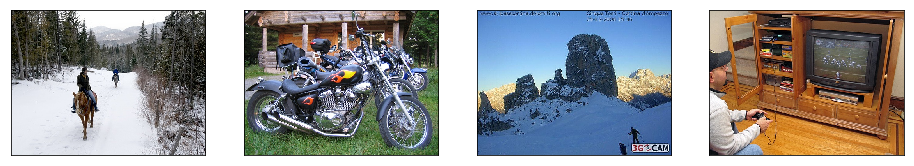

In [10]:
#show sample images
no_samples = 5
sample_images = random.choices(list(imagedir.iterdir()),k=no_samples)
fig, axs = plt.subplots(nrows=math.floor(no_samples/4),ncols=4,figsize=(16,12))
for idx, ax in enumerate(axs.flat):
    im = open_image(sample_images[idx])
    show_img(im,ax=ax)

### Display bounding box of single image
Here we can see that pascal voc annoations are in the format [x0,y0,width,height], where (x0, y0) is the top left hand corner of the BB. (0,0) would be the top-left corner of the image. 

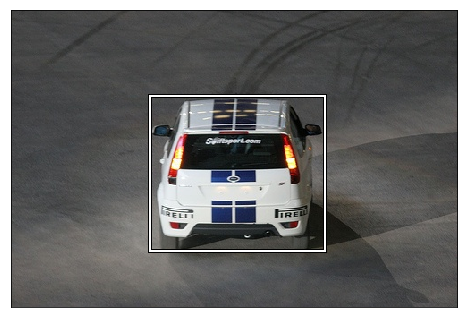

In [11]:
image_name = '000012.jpg'
image_path = imagedir.joinpath(image_name)
fig, axs = plt.subplots(1,1,figsize=(8,8))
im = open_image(image_path.as_posix())
axs.imshow(im)
axs.get_xaxis().set_visible(False)
axs.get_yaxis().set_visible(False)
bb_voc = [155, 96, 196, 174]
# bb_voc = [0, 96, 196, 174]
draw_rect(axs,bb_voc)

Let us collect annotations for each image, with bounding boxes in numpy format

In [12]:
train_img_anno_np = collections.defaultdict(lambda: [])
for anno in train_json['annotations']:
    if anno['ignore']:
        continue
    bb = anno['bbox']
    #convert bounding boxes to numpy format
    bb = bb_hw_to_np(bb)
    train_img_anno_np[anno['image_id']].append((bb,anno['category_id']))
        
len(train_img_anno_np)

2501

### Display image with annotations

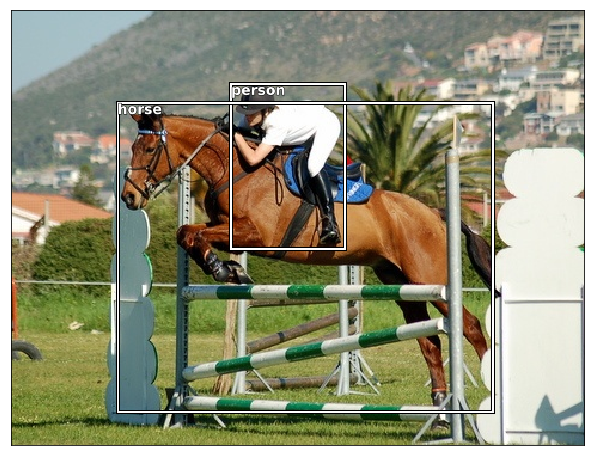

In [14]:
def draw_idx(idx, annos=None):
    filename = train_id_filename[idx]
    image_path = imagedir.joinpath(filename)
    img = open_image(image_path)
    fig, ax = plt.subplots(figsize=(16,8))
    show_img(img,ax=ax)
    #if not annoatations are provide, draw all VOC annotations
    if not annos:
        annos = train_img_anno_np[idx]
    for anno in annos:
        bb = bb_np_to_hw(anno[0])
        draw_rect(ax,bb)
        draw_text(ax,bb[:2],category_id_names[anno[1]])
        
draw_idx(17)

### Find largest bounding box in each image

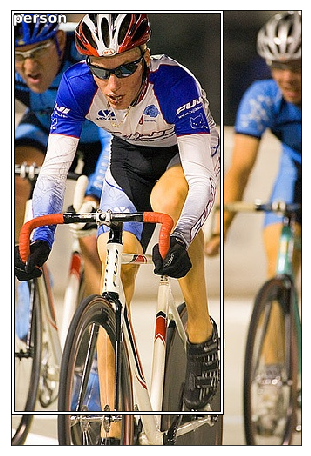

In [15]:
#get the largest annotation by size
def get_largest_anno(idx):
    bbs_np = train_img_anno_np[idx]
    if not bbs_np:
        return
    largest_area = 0
    largest_i = 0
    for i, bb in enumerate(bbs_np):
        area = (bb[0][2] - bb[0][0]) * (bb[0][3] - bb[0][1])
        if area >= largest_area:
            largest_area = area
            largest_i = i
    return bbs_np[largest_i]

#test it
anno = get_largest_anno(23)
draw_idx(23,annos=[anno])

## 1. Largest objects in each image
Here we ignore the bounding boxes
### Create a dictionary of largest annotations

In [23]:
train_img_large_anno_np = {idx:get_largest_anno(idx) for idx, o in train_img_anno_np.items()}
print(len(train_img_large_anno_np))

#save this csv to tmp
pascal_home.joinpath('tmp').mkdir(exist_ok=True)
large_csv = pascal_home.joinpath('tmp/lrg.csv')

#create a df with filename and category of largest image

filenames = [train_id_filename[idx] for idx in train_id_filename.keys()]
print(filenames[:5])
cat = [category_id_names[train_img_large_anno_np[idx][1]] for idx in train_id_filename.keys()]
# print('filenames: ', len(filenames))
print(cat[:5] )
df = pd.DataFrame({'filename':filenames, 'cat': cat},columns=['filename','cat'])
print(df.head())
df.to_csv(str(large_csv),index=False)

f_model = resnet34
batchsize = 64
size = 224

tfms = tfms_from_model(f_model,sz=224,aug_tfms=transforms_side_on,crop_type=CropType.NO)
md = ImageClassifierData.from_csv(pascal_home,jpeg_rel,str(large_csv),tfms=tfms,bs=batchsize)

2501
['000012.jpg', '000017.jpg', '000023.jpg', '000026.jpg', '000032.jpg']
['car', 'horse', 'person', 'car', 'aeroplane']
     filename        cat
0  000012.jpg        car
1  000017.jpg      horse
2  000023.jpg     person
3  000026.jpg        car
4  000032.jpg  aeroplane


NameError: name 'ImageClassifierData' is not defined

In [316]:
x,y=next(iter(md.val_dl))

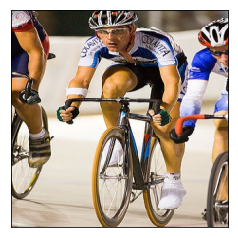

In [317]:
show_img(md.val_ds.denorm(to_np(x))[0]);

In [321]:
print(x.shape)
print(y.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [319]:
learn = ConvLearner.pretrained(f_model,md,metrics=[accuracy])
learn.opt_fn = optim.Adam

 78%|███████▊  | 25/32 [00:13<00:03,  1.88it/s, loss=11.8]

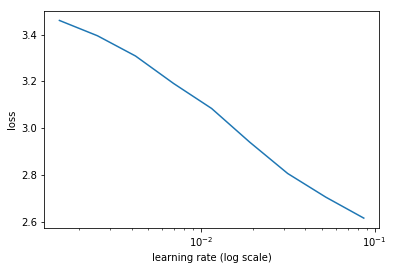

In [322]:
lrf=learn.lr_find(1e-5,100)
learn.sched.plot()

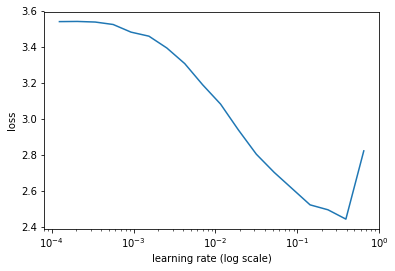

In [323]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [324]:
lr = 2e-2
learn.fit(lr,1,cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.287041   0.663597   0.784     


[array([0.6636]), 0.7840000009536743]

 84%|████████▍ | 27/32 [00:15<00:02,  1.79it/s, loss=3.77]

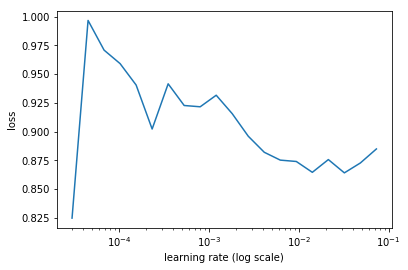

In [326]:
lrs = np.array([lr/1000,lr/100,lr])
learn.freeze_to(-2)
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [327]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.793627   0.547647   0.82      


[array([0.54765]), 0.8200000023841858]

In [328]:
learn.unfreeze()
learn.fit(lrs/5,1,cycle_len=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.645397   0.55816    0.822     
    1      0.44744    0.546801   0.834     


[array([0.5468]), 0.8340000023841858]

In [329]:
learn.save('clas_one')
learn.load('clas_one')

In [331]:
x,y = next(iter(md.val_dl))
print(x.shape)
print(y.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


torch.Size([64, 20])
[14 17  2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


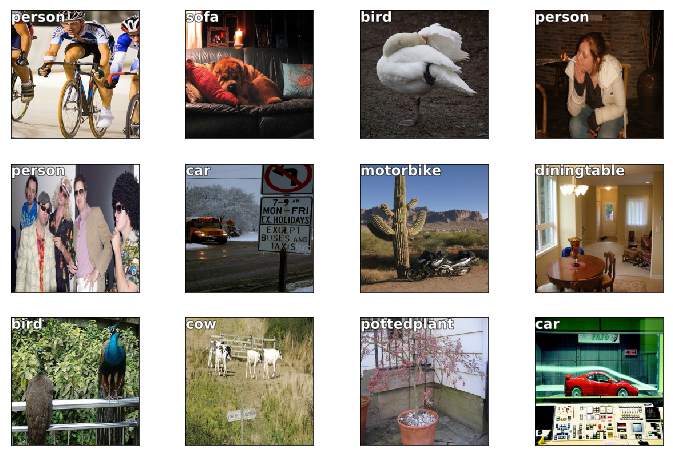

In [354]:
probs = F.softmax(predict_batch(learn.model,x),-1)
print(probs.shape)
x, preds = to_np(x), to_np(probs)
preds = np.argmax(preds,-1)
print(preds[:3])

#let us view the results
fig, axes = plt.subplots(3,4,figsize=(12,8))
for i,ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    pred_name = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax,(0,0),pred_name)


## Predict Bounding box only
Here we ignore the class. We just want the model to learn how to identify a large object

In [26]:
bb_csv = pascal_home.joinpath('tmp/bb.csv')

#let us again see one element of LARGE training image annotations
print('Training image annotatoin example: ', train_img_large_anno_np[12], '  no of images: ', len(train_img_large_anno_np.keys()))
bb_list = [train_img_large_anno_np[idx][0] for idx in train_ids]
bb_str_list = [' '.join(str(p) for p in o) for o in bb_list]
print('space separated annotations: ', bb_str_list[:2])

#create the dataframe
df = pd.DataFrame({
    'filename': [train_id_filename[o] for o in train_ids],
    'bbox': bb_str_list
}, columns=['filename','bbox'])
#write to csv
df.to_csv(bb_csv,index=False)

#let us check the contents of the csv
bb_csv.open().readlines()[:3]

Training image annotatoin example:  (array([ 96, 155, 269, 350]), 7)   no of images:  2501
space separated annotations:  ['96 155 269 350', '77 89 335 402']


['filename,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n']

In [27]:
#define the model, batchsize and size of image
f_model = resnet34
batch_size=64
image_size=224

#augmentations to apply
augs = [RandomFlip(),
        RandomRotate(30),
        RandomLighting(0.1,0.1)
        ]

#apply the transformations
tfms = tfms_from_model(f_model,image_size,aug_tfms=augs,crop_type=CropType.NO)
md = ImageClassifierData.from_csv(pascal_home,jpeg_rel, bb_csv, bs=batch_size, tfms=tfms, continuous=True)

[ 63. 115. 374. 355.] [115.  63. 241. 312.]  shape:  (224, 224, 3)
[ 63. 115. 374. 355.] [115.  63. 241. 312.]  shape:  (224, 224, 3)
[ 63. 115. 374. 355.] [115.  63. 241. 312.]  shape:  (224, 224, 3)
[ 63. 115. 374. 355.] [115.  63. 241. 312.]  shape:  (224, 224, 3)
[ 63. 115. 374. 355.] [115.  63. 241. 312.]  shape:  (224, 224, 3)
[ 63. 115. 374. 355.] [115.  63. 241. 312.]  shape:  (224, 224, 3)


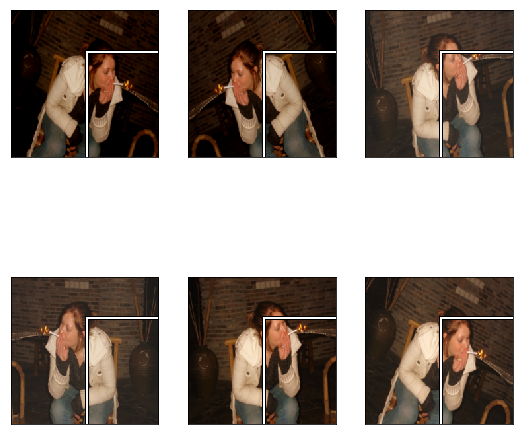

In [28]:
idx=3
fig, axes = plt.subplots(2,3,figsize=(9,9))
for i, ax in enumerate(axes.flat):
    x, y = next(iter(md.aug_dl))
    img = md.val_ds.denorm(to_np(x))[idx]
    b = bb_np_to_hw(to_np(y[idx]))
    print(to_np(y[idx]), b,' shape: ', img.shape)
    show_img(img, ax=ax)
    draw_rect(ax, b)

We can see that the bounding boxes are not transformed while augmenting the images. Let us now transform Y also during the augmentation. 

[ 14.  49. 222. 196.] [ 49.  14. 148. 209.]  shape:  (224, 224, 3)
[ 38.  52. 220. 157.] [ 52.  38. 106. 183.]  shape:  (224, 224, 3)
[ 34.  49. 222. 163.] [ 49.  34. 115. 189.]  shape:  (224, 224, 3)
[ 21.  54. 222. 188.] [ 54.  21. 135. 202.]  shape:  (224, 224, 3)
[ 10.  45. 222. 202.] [ 45.  10. 158. 213.]  shape:  (224, 224, 3)
[ 37.  64. 222. 172.] [ 64.  37. 109. 186.]  shape:  (224, 224, 3)


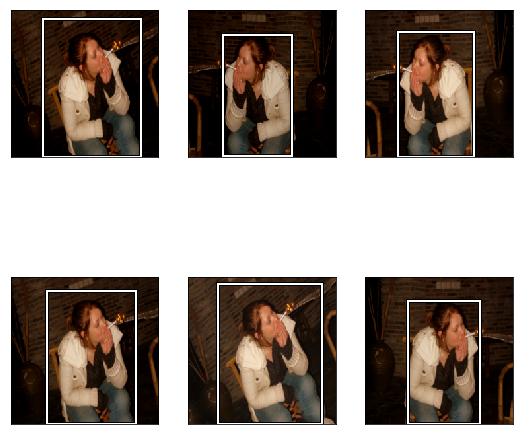

In [29]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model,image_size,aug_tfms=augs,crop_type=CropType.NO,tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(pascal_home,jpeg_rel, bb_csv, bs=batch_size, tfms=tfms, continuous=True)

idx=3
fig, axes = plt.subplots(2,3,figsize=(9,9))
for i, ax in enumerate(axes.flat):
    x, y = next(iter(md.aug_dl))
    img = md.val_ds.denorm(to_np(x))[idx]
    b = bb_np_to_hw(to_np(y[idx]))
    print(to_np(y[idx]), b,' shape: ', img.shape)
    show_img(img, ax=ax)
    draw_rect(ax, b)

In [30]:
head_reg4 = torch.nn.Sequential(Flatten(),torch.nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.optim = optim.Adam
learn.crit = nn.L1Loss()

 72%|███████▏  | 23/32 [00:16<00:06,  1.39it/s, loss=427]

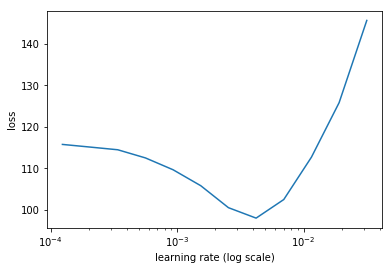

In [31]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [32]:
lr=2e-3
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      50.646445  33.023884 
    1      40.457317  32.295416 
    2      32.898565  28.095091 


[array([28.09509])]

 91%|█████████ | 29/32 [00:21<00:02,  1.36it/s, loss=75.2]

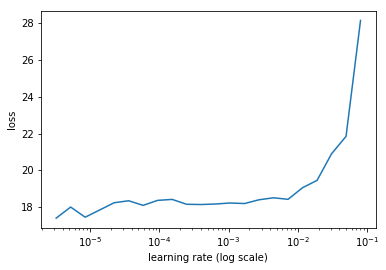

In [40]:
learn.freeze_to(-2)

lrs = np.array([lr/100,lr/10,lr])
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [41]:
learn.fit(lrs, 2,cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      18.779564  21.264286 
    1      19.000739  21.280463 
    2      18.127712  21.024659 


[array([21.02466])]

In [35]:
learn.freeze_to(-3)
learn.fit(lrs, 2, cycle_len=2)

epoch      trn_loss   val_loss   
    0      21.317433  22.737064 
    1      20.444661  22.103001 
    2      20.46588   21.657921 
    3      19.596542  21.49046  


[array([21.49046])]

In [36]:
learn.save('reg4')
learn.load('reg4')

In [37]:
x, y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


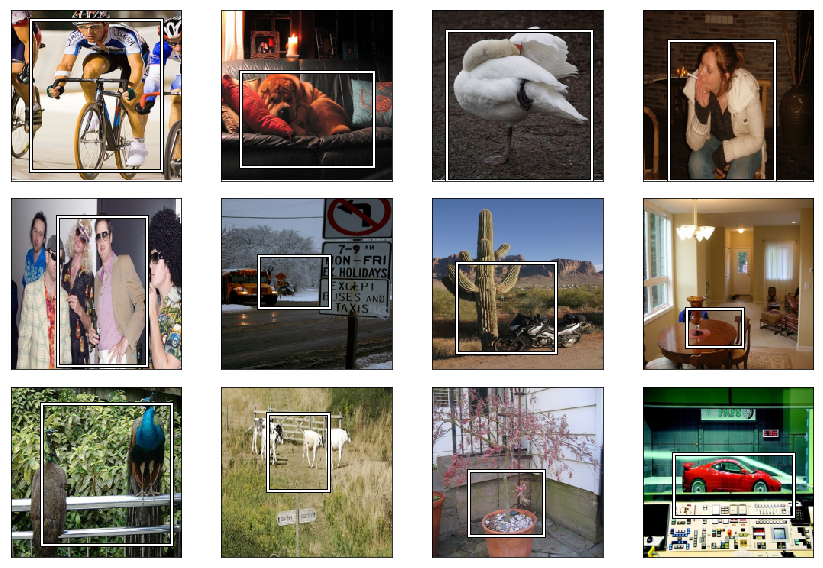

In [38]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_np_to_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## Single Object Detection

In [43]:
#concat bbs and classes for the target
def conct_label_ds(Dataset):
    def __init__(self, ds,y2):
        self.ds, self.y2 = ds, y2
        
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y, y2[i]))

# detection l1 loss 
def dtn_l1_loss(input, target):
    #get the bounding boxes and classes
    bb_i, c_i = input[:,:4],input[:,4:]
    bb_t, c_t = target
    bb_i = F.sigmoid(bb_i) * 224
    return F.l1_loss(bb_i,bb_t) + 20*F.cross_entropy(c_t, c_i)

# detection class accuracy
def dtn_class_accuracy(input, target):
    _, c_t = target
    c_i = input[:,4:]
    return accuracy(c_i, c_t)

    
    